In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from scipy import stats as st


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset

In [2]:
metadata_all_raw = pd.read_csv("/content/drive/My Drive/LungAtlas/krasnow_hlca_10x_metadata_upload.csv")

In [3]:
metadata_epi_str_idx = [i for i, x in enumerate(metadata_all_raw["compartment"]) if (x in ["Epithelial", "Stromal"])]
metadata_epi_str = metadata_all_raw.iloc[metadata_epi_str_idx, :]
metadata_epi_str = metadata_epi_str[metadata_epi_str["free_annotation"] != "Pericyte"]
metadata_epi_str = metadata_epi_str[metadata_epi_str["free_annotation"] != "Mesothelial"]
metadata_epi_str = metadata_epi_str.reset_index(drop=True)

metadata_epi_idx = [i for i, x in enumerate(metadata_epi_str["compartment"]) if (x == "Epithelial")]
metadata_str_idx = [i for i, x in enumerate(metadata_epi_str["compartment"]) if (x == "Stromal")]

In [4]:
data_epi_str_raw_gene = pd.read_csv("/content/drive/My Drive/LungAtlas/data_epi_str_raw_gene.csv", index_col="Unnamed: 0")

In [5]:
sc = StandardScaler()
data_epi_str_gene_std = pd.DataFrame(sc.fit_transform(data_epi_str_raw_gene), index=data_epi_str_raw_gene.index, columns=data_epi_str_raw_gene.columns)
data_epi_str_gene_std = data_epi_str_gene_std.round(3)

In [ ]:
data_epi_str_gene_std


,P2_1_CACTCCAGTACCTACA,P2_1_CGGAGCTCAGGTTTCA,P2_5_TGAAAGAAGTCGAGTG,P2_5_TTTACTGGTAGCGCTC,P2_8_ACGAGGACACGGTTTA,P2_8_ACTGAGTGTGACCAAG,P2_8_CATATGGAGACAAGCC,P2_8_CCAGCGATCGCCAAAT,P2_8_CGGCTAGTCCAAATGC,P2_8_GGCCGATTCCTGCAGG,P2_8_GTCCTCATCCGCTGTT,P2_1_AACACGTTCCATGAGT,P2_1_ACGGGTCTCTTTACGT,P2_1_CAGAGAGTCGCCTGAG,P2_1_CCCAATCGTGTAATGA,P2_1_CGTTCTGTCATAGCAC,P2_1_TCTTCGGAGACCCACC,P2_1_TGTTCCGGTCTCCATC,P2_2_GGGAATGAGGGCACTA,P2_4_AACTCTTAGACACTAA,P2_4_ACACCAAAGCGTAATA,P2_4_ACTGTCCGTAAGAGGA,P2_4_ATAACGCAGGGATACC,P2_4_CATGGCGCAAGCGCTC,P2_4_GCCTCTATCGTGGTCG,P2_4_TGACGGCCACCAGCAC,P2_5_AAGGCAGGTGAGGCTA,P2_5_ACAGCCGAGCTGAACG,P2_5_ACATACGAGAAGGACA,P2_5_AGGGAGTAGAGGGCTT,P2_5_ATCCGAAGTTGAACTC,P2_5_ATTCTACAGTTCCACA,P2_5_CAACCTCGTACACCGC,P2_5_CAAGAAACATATACCG,P2_5_CACAAACGTATAGGTA,P2_5_CACCAGGAGGCGATAC,P2_5_CATATTCTCGGAAATA,P2_5_CATCGGGCACCACGTG,P2_5_CCTTCCCGTCTTGATG,P2_5_CTAATGGAGGATTCGG,...,P3_5_GTGCGGTTCTCTAAGG,P3_5_GTGGGTCGTGTAAGTA,P3_5_GTGTGCGTCGATGAGG,P3_5_GTTAAGCGTGTCTGAT,P3_5_GTTACAGGTCAGAGGT,P3_5_GTTCGGGGTCAGCTAT,P3_5_GTTTCTACAACTGCTA,P3_5_TACCTTACAGCGTAAG,P3_5_TACGGTAAGAAGGTTT,P3_5_TACGGTAAGCTAGTCT,P3_5_TACGGTACAGACAAAT,P3_5_TACTCATTCCCACTTG,P3_5_TATCAGGCACCCAGTG,P3_5_TATCTCATCGGACAAG,P3_5_TCACAAGCAGCCAGAA,P3_5_TCAGCAACAGATGGCA,P3_5_TCCACACCATGTCCTC,P3_5_TCGAGGCGTAACGTTC,P3_5_TCGAGGCTCCTGCTTG,P3_5_TGACAACAGCTAACAA,P3_5_TGACAACGTCAATGTC,P3_5_TGACGGCGTTCCACTC,P3_5_TGAGCATAGAAACGCC,P3_5_TGATTTCCAAAGCGGT,P3_5_TGCTGCTTCGGGAGTA,P3_5_TGGTTCCGTAGGGACT,P3_5_TTCGGTCAGGACATTA,P3_5_TTGTAGGAGTGTGGCA,P3_5_TTTACTGGTTTCCACC,P3_5_TTTACTGTCCCAAGAT,P3_6_AAAGCAAAGGGAACGG,P3_6_ACTTGTTCATAGTAAG,P3_6_AGCTCTCCATAGGATA,P3_6_AGGTCCGTCAGGCAAG,P3_6_CCTACCAGTACTTAGC,P3_6_GGCGACTAGACTTGAA,P3_6_TCGTACCCAGCTCGAC,P3_6_TGCTACCAGTCGCCGT,P3_7_CAGCTAATCCCTTGTG,P3_7_TTTCCTCTCTGGCGAC
DDX11L1,-0.052,-0.06,-0.06,-0.06,-0.035,-0.07,-0.072,-0.048,-0.051,-0.061,-0.058,-0.071,-0.053,-0.06,-0.112,-0.062,-0.058,-0.071,-0.087,-0.084,-0.059,-0.081,-0.067,-0.058,-0.077,-0.07,-0.075,-0.064,-0.095,-0.081,-0.065,-0.065,-0.055,-0.062,-0.06,-0.07,-0.087,-0.058,-0.035,-0.095,...,-0.084,-0.093,-0.095,-0.093,-0.061,-0.101,-0.08,-0.062,-0.071,-0.05,-0.062,-0.077,-0.07,-0.076,-0.058,-0.056,-0.038,-0.103,-0.075,-0.099,-0.051,-0.056,-0.072,-0.075,-0.09,-0.059,-0.079,-0.061,-0.085,-0.076,-0.083,-0.102,-0.09,-0.074,-0.044,-0.082,-0.059,-0.067,-0.054,-0.083
WASH7P,-0.052,-0.06,-0.06,-0.06,-0.035,-0.07,-0.072,-0.048,-0.051,-0.061,-0.058,-0.071,-0.053,-0.06,0.401,-0.062,-0.058,-0.071,-0.087,0.297,-0.059,-0.081,-0.067,-0.058,0.414,-0.07,-0.075,-0.064,-0.095,-0.081,-0.065,-0.065,-0.055,-0.062,-0.06,-0.07,-0.087,-0.058,-0.035,-0.095,...,-0.084,-0.093,-0.095,-0.093,-0.061,-0.101,-0.08,-0.062,-0.071,-0.05,-0.062,-0.077,-0.07,-0.076,-0.058,-0.056,-0.038,-0.103,0.508,-0.099,-0.051,-0.056,-0.072,-0.075,-0.09,-0.059,-0.079,-0.061,-0.085,-0.076,-0.083,-0.102,-0.09,-0.074,-0.044,-0.082,-0.059,-0.067,-0.054,-0.083
FAM138A,-0.052,-0.06,-0.06,-0.06,-0.035,-0.07,-0.072,-0.048,-0.051,-0.061,-0.058,-0.071,-0.053,-0.06,-0.112,-0.062,-0.058,-0.071,-0.087,-0.084,-0.059,-0.081,-0.067,-0.058,-0.077,-0.07,-0.075,-0.064,-0.095,-0.081,-0.065,-0.065,-0.055,-0.062,-0.06,-0.07,-0.087,-0.058,-0.035,-0.095,...,-0.084,-0.093,-0.095,-0.093,-0.061,-0.101,-0.08,-0.062,-0.071,-0.05,-0.062,-0.077,-0.07,-0.076,-0.058,-0.056,-0.038,-0.103,-0.075,-0.099,-0.051,-0.056,-0.072,-0.075,-0.09,-0.059,-0.079,-0.061,-0.085,-0.076,-0.083,-0.102,-0.09,-0.074,-0.044,-0.082,-0.059,-0.067,-0.054,-0.083
FAM138C,-0.052,-0.06,-0.06,-0.06,-0.035,-0.07,-0.072,-0.048,-0.051,-0.061,-0.058,-0.071,-0.053,-0.06,-0.112,-0.062,-0.058,-0.071,-0.087,-0.084,-0.059,-0.081,-0.067,-0.058,-0.077,-0.07,-0.075,-0.064,-0.095,-0.081,-0.065,-0.065,-0.055,-0.062,-0.06,-0.07,-0.087,-0.058,-0.035,-0.095,...,-0.084,-0.093,-0.095,-0.093,-0.061,-0.101,-0.08,-0.062,-0.071,-0.05,-0.062,-0.077,-0.07,-0.076,-0.058,-0.056,-0.038,-0.103,-0.075,-0.099,-0.051,-0.056,-0.072,-0.075,-0.09,-0.059,-0.079,-0.061,-0.085,-0.076,-0.083,-0.102,-0.09,-0.074,-0.044,-0.082,-0.059,-0.067,-0.054,-0.083
FAM1

In [ ]:
metadata_epi_str

,Unnamed: 0,nGene,nUMI,orig.ident,channel,tissue,region,percent.ribo,free_annotation,patient,sample,location,magnetic.selection,preparation.site,compartment,prolif.score,MPP.score,HSC.score,gen.egress.score,lymphocyte.egress.score,myeloid.egress.score
0,P2_1_CACTCCAGTACCTACA,1554,3001,Human Lung 10x - Patient 2,P2_1,lung,normal,0.136954,Vascular Smooth Muscle,2,distal 2,distal,epithelial,biohub,Stromal,-1.253383,-0.887927,-2.778003,-2.387315,-1.080515,4.781629
1,P2_1_CGGAGCTCAGGTTTCA,1863,3989,Human Lung 10x - Patient 2,P2_1,lung,normal,0.099524,Vascular Smooth Muscle,2,distal 2,distal,epithelial,biohub,Stromal,-1.253383,-0.887927,-2.778003,-1.039236,-2.498730,-3.922822
2,P2_5_TGAAAGAAGTCGAGTG,1192,2054,Human Lung 10x - Patient 2,P2_5,lung,normal,0.104187,Vascular Smooth Muscle,2,distal 2,distal,stromal,biohub,Stromal,-1.253383,-0.887927,-0.338171,1.870667,-4.299489,-3.922822
3,P2_5_TTTACTGGTAGCGCTC,1645,3407,Human Lung 10x - Patient 2,P2_5,lung,normal,0.116231,Vascular Smooth Muscle,2,distal 2,distal,stromal,biohub,Stromal,-1.253383,-0.887927,5.981087,-0.562855,-2.134197,-2.579667
4,P2_8_ACGAGGACACGGTTTA,1215,2315,Human Lung 10x - Patient 2,P2_8,lung,normal,0.095032,Vascular Smooth Muscle,2,medial 2,medial,stromal,biohub,Stromal,-1.253383,-0.887927,-2.778003,-2.387315,-0.331134,-3.922822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12798,P3_6_GGCGACTAGACTTGAA,1605,3865,Human Lung 10x - Patient 3,P3_6,lung,normal,0.164036,Airway Smooth Muscle,3,distal 3,distal,epithelial,biohub,Stromal,-1.253383,-0.887927,-2.778003,-2.387315,-2.280461,-1.269466
12799,P3_6_TCGTACCCAGCTCGAC,1814,4729,Human Lung 10x - Patient 3,P3_6,lung,normal,0.091986,Airway Smooth Muscle,3,distal 3,distal,epithelial,biohub,Stromal,-1.253383,-0.887927,12.203523,0.559467,-2.410973,-1.431062
12800,P3_6_TGCTACCAGTCGCCGT,1219,2540,Human Lung 10x - Patient 3,P3_6,lung,normal,0.117717,Airway Smooth Muscle,3,distal 3,distal,epithelial,biohub,Stromal,-1.253383,-0.887927,-2.778003,-2.387315,-1.930737,-3.922822
12801,P3_7_CAGCTAATCCCTTGTG,1195,2468,Human Lung 10x - Patient 3,P3_7,lung,normal,0.117909,Airway Smooth Muscle,3,distal 3,distal,immune and endothelial,biohub,Stromal,-1.253383,9.208898,7.329030,-2.387315,-2.443100,-3.922822


In [6]:
def ttest_row(x):
  _, pvalue = st.ttest_ind(x[metadata_epi_idx], x[metadata_str_idx])
  return pvalue

pvalues = data_epi_str_gene_std.apply(ttest_row, axis=1)
pvalues = pvalues.values
gene1024 = np.argsort(pvalues)[:1024]
data_epi_str_gene_std_1024 = data_epi_str_gene_std.iloc[gene1024,]

In [7]:
X = data_epi_str_gene_std_1024.T

label = metadata_epi_str["compartment"].values

X = np.array(X.astype("f"))
y = np.where(label=="Epithelial", 0, 1).reshape(-1, 1)

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=0)

train_X = torch.Tensor(train_X)
test_X = torch.Tensor(test_X)
train_y = torch.Tensor(train_y)
test_y = torch.Tensor(test_y)

train = TensorDataset(train_X, train_y)
test = TensorDataset(test_X, test_y)

train_loader = DataLoader(train, batch_size=30, shuffle=True)
test_loader = DataLoader(test, batch_size=30, shuffle=False)

In [8]:
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

In [9]:
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        self.fc1 = nn.Linear(1024, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(256, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(64, 1)
        self.sgm = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        x = self.sgm(x)
        return x

Nmodel = CNN()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(Nmodel.parameters(), lr=0.01)

for epoch in range(10):
  total_loss1 = 0
  total_loss2 = 0
  for x_train, y_train in train_loader:
    z_train = Nmodel(x_train)
    loss=criterion(z_train, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss1 += loss.item()
  for x_test, y_test in test_loader:
    z_test = Nmodel(x_test)
    loss=criterion(z_test, y_test)
    total_loss2 += loss.item()

#  print(epoch, total_loss1/len(train))
  print(epoch, total_loss1/len(train), total_loss2/len(test))

0 0.022387097995045176 0.021088279513165803
1 0.020669937442229423 0.020567864307618058
2 0.020331144327066113 0.02033578870073979
3 0.020200359375535965 0.020229959455331476
4 0.0201026765926814 0.0201597851917456
5 0.020048875398781123 0.020108160005328897
6 0.019995371681059554 0.020085057375348204
7 0.019973004115696323 0.0200528461502102
8 0.019950133082550548 0.020038051444168717
9 0.019957321203679133 0.020020873785856784


In [ ]:
pred_train_y = Nmodel(train_X).detach().numpy().copy()
pred_train_y = np.where(pred_train_y<0.5, 0, 1)
cm1 = confusion_matrix(train_y, pred_train_y)
cm1

array([[7528,    1],
       [  13, 2700]])

In [ ]:
pred_test_y = Nmodel(test_X).detach().numpy().copy()
pred_test_y = np.where(pred_test_y<0.5, 0, 1)
cm2 = confusion_matrix(test_y, pred_test_y)
cm2

array([[1878,    0],
       [   7,  676]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

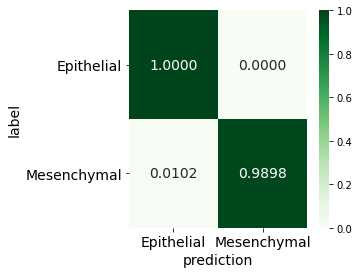

In [ ]:
from google.colab import files

labels = ["Epithelial", "Mesenchymal"]

cm2 = confusion_matrix(test_y, pred_test_y, normalize="true")
fig, ax = plt.subplots(figsize=(4, 4))

sns.heatmap(cm2, cmap="Greens", xticklabels=labels, yticklabels=labels, annot=True, annot_kws=dict(fontsize=14) , fmt=".4f", ax=ax)
plt.xticks(fontsize=14)
plt.yticks(rotation=0, fontsize=14)

ax.set_xlabel("prediction", size=14)
ax.set_ylabel("label", size=14)

plt.savefig("nn_heatmap.jpg", format="jpg", bbox_inches="tight")
files.download("nn_heatmap.jpg")
plt.show()

In [10]:
tcga_std_gene = pd.read_csv("/content/drive/My Drive/TCGA/tcga_std_gene.csv", index_col="Unnamed: 0")
tcga_std_gene_1024 = tcga_std_gene.iloc[gene1024,]


val_X = np.array(tcga_std_gene_1024.T.astype("f"))
val_X = torch.Tensor(val_X)
pred_val_y = Nmodel(val_X).detach().numpy().copy()


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

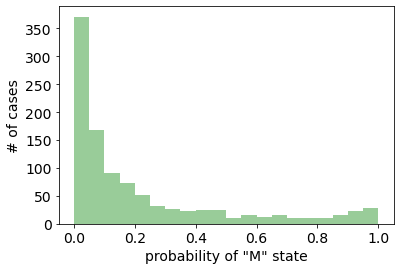

In [11]:
from google.colab import files

fig, ax = plt.subplots(figsize=(6, 4))

sns.distplot(pred_val_y, bins=20, kde=False, color="green", norm_hist=False)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ax.set_xlabel('probability of "M" state', size=14)
ax.set_ylabel("# of cases", size=14)

plt.savefig("nn_histogram.jpg", format="jpg", bbox_inches="tight")
files.download("nn_histogram.jpg")
plt.show()

In [ ]:
pred_val_y_bi = np.where(pred_val_y<0.5, 0, 1).reshape(1, -1)[0]
np.mean(pred_val_y_bi)

0.14671814671814673

In [ ]:
pred_prog = pd.DataFrame(columns=["case_id", "project_id", "age", "gender", "stage", "prediction", "event", "days"])

for i in range(len(tcga_std_gene.columns)):
  id = tcga_std_gene.columns[i]
  prediction = pred_val_y_bi[i]

  with open("/content/drive/My Drive/TCGA/clinical.tsv") as f:
    for s_line in f:
      sample = s_line.split("\t")
      if sample[0] == id:
        project = sample[2]
        age = sample[3]
        gender = sample[11]
        stage = sample[26]
        if sample[15] == "Dead":
          event = 1
        elif sample[15] == "Alive":
          event = 0
        days = sample[47]
        break

  pred_prog.loc[i] = [id, project, age, gender, stage, prediction, event, days]      

pred_prog

,case_id,project_id,age,gender,stage,prediction,event,days
0,9a13a742-ff9a-4432-a7ce-7fcbb753be01,TCGA-LUSC,48,male,Stage IA,0,0,952
1,34f7b63b-7a49-4b29-ab72-d880d87fb7b3,TCGA-LUSC,65,male,Stage IB,0,1,475
2,34040b83-7e8a-4264-a551-b16621843e28,TCGA-LUAD,70,male,Stage IV,0,0,0
3,df7cfd84-a36a-44a0-b39f-a9ea1e0fd500,TCGA-LUSC,63,male,Stage IB,1,0,28
4,9b4eeecb-6aff-435b-a244-ec362af92b7f,TCGA-LUAD,68,male,Stage IIB,0,0,882
...,...,...,...,...,...,...,...,...
1031,ccda26c1-a6d6-4317-8cf8-8a87e15ce12e.2,TCGA-LUAD,63,female,Stage IIB,0,0,944
1032,9b07ef0c-1329-4341-a5a4-42abe7a6737c,TCGA-LUSC,62,male,Stage IB,0,0,3123
1033,abc753f0-5ae2-4bec-96b8-6a05d84bf1c1,TCGA-LUSC,69,female,Stage IIB,1,1,'--
1034,0d3c11b5-856e-4d41-b94a-b2e32f9c5792,TCGA-LUSC,55,male,Stage IA,0,1,'--


In [ ]:
pred_prog.groupby("prediction")["stage"].value_counts()

prediction  stage     
0           Stage IB      252
            Stage IA      200
            Stage IIB     139
            Stage IIIA    118
            Stage IIA      97
            Stage IV       29
            Stage IIIB     25
            '--            11
            Stage I         8
            Stage III       3
            Stage II        2
1           Stage IB       48
            Stage IIB      27
            Stage IIIA     23
            Stage IA       22
            Stage IIA      19
            Stage IIIB      5
            Stage IV        4
            Stage II        2
            '--             1
            Stage III       1
Name: stage, dtype: int64

In [ ]:
pip install lifelines

     |████████████████████████████████| 348kB 4.4MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-cp36-none-any.whl size=4035 sha256=656f5f081dd92ab85dd2a04e77e03d8e88e349c879e8d044ab8d4a2243b1411c
  Stored in directory: /root/.cache/pip/wheels/dc/68/dc/91321c55fba449755524481854f5be70d41912b8f886f908bb
Successfully built autograd-gamma


In [ ]:
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter

/usr/local/lib/python3.6/dist-packages/lifelines/utils/__init__.py:1175: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/usr/local/lib/python3.6/dist-packages/lifelines/utils/__init__.py:1175: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

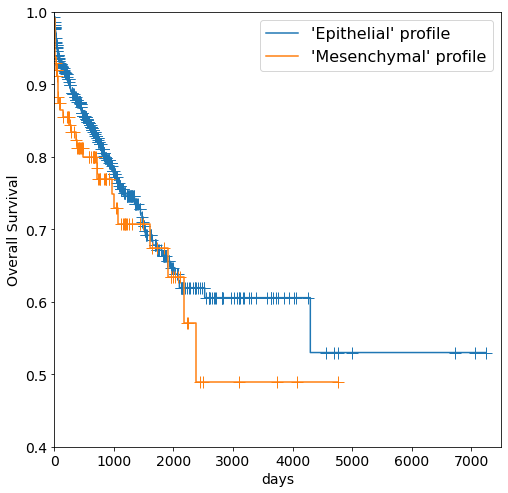

In [ ]:
from google.colab import files

labels = ["'Epithelial' profile", "'Mesenchymal' profile"]

pred_prog = pred_prog[pred_prog["days"] != "'--"]

kmf = KaplanMeierFitter()

plt.figure(figsize=(8, 8))
ax = None
for name, group in pred_prog.groupby('prediction'):
    kmf.fit(group['days'], event_observed=group['event'],
            label = labels[name])
    # 描画する Axes を指定。None を渡すとエラーになるので場合分け
    if ax is None:
        ax = kmf.plot(show_censors=True, ci_show=False)
    else:
        ax = kmf.plot(ax=ax, show_censors=True, ci_show=False)
#plt.title('Kaplan-Meier Curve')
plt.xlim(0, 7500)
plt.ylim(0.4, 1.0)
plt.xticks(fontsize=14)
plt.yticks(rotation=0, fontsize=14)

ax.set_xlabel('days', size=14)
ax.set_ylabel("Overall Survival", size=14)

plt.legend(fontsize=16)

plt.savefig("nn_survival.jpg", format="jpg", bbox_inches="tight")
files.download("nn_survival.jpg")
plt.show()

In [12]:
pred_prog2 = pd.DataFrame(columns=["case_id", "project_id", "age", "gender", "stage", "prediction", "event", "days"])

for i in range(len(tcga_std_gene.columns)):
  id = tcga_std_gene.columns[i]
  prediction = pred_val_y[i][0]

  with open("/content/drive/My Drive/TCGA/clinical.tsv") as f:
    for s_line in f:
      sample = s_line.split("\t")
      if sample[0] == id:
        project = sample[2]
        age = sample[3]
        gender = sample[11]
        stage = sample[26]
        if sample[15] == "Dead":
          event = 1
        elif sample[15] == "Alive":
          event = 0
        days = sample[47]
        break

  pred_prog2.loc[i] = [id, project, age, gender, stage, prediction, event, days]      

pred_prog2

,case_id,project_id,age,gender,stage,prediction,event,days
0,9a13a742-ff9a-4432-a7ce-7fcbb753be01,TCGA-LUSC,48,male,Stage IA,0.444534,0,952
1,34f7b63b-7a49-4b29-ab72-d880d87fb7b3,TCGA-LUSC,65,male,Stage IB,0.248288,1,475
2,34040b83-7e8a-4264-a551-b16621843e28,TCGA-LUAD,70,male,Stage IV,0.018243,0,0
3,df7cfd84-a36a-44a0-b39f-a9ea1e0fd500,TCGA-LUSC,63,male,Stage IB,0.873775,0,28
4,9b4eeecb-6aff-435b-a244-ec362af92b7f,TCGA-LUAD,68,male,Stage IIB,0.026436,0,882
...,...,...,...,...,...,...,...,...
1031,ccda26c1-a6d6-4317-8cf8-8a87e15ce12e.2,TCGA-LUAD,63,female,Stage IIB,0.262489,0,944
1032,9b07ef0c-1329-4341-a5a4-42abe7a6737c,TCGA-LUSC,62,male,Stage IB,0.094055,0,3123
1033,abc753f0-5ae2-4bec-96b8-6a05d84bf1c1,TCGA-LUSC,69,female,Stage IIB,0.853879,1,'--
1034,0d3c11b5-856e-4d41-b94a-b2e32f9c5792,TCGA-LUSC,55,male,Stage IA,0.079745,1,'--


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

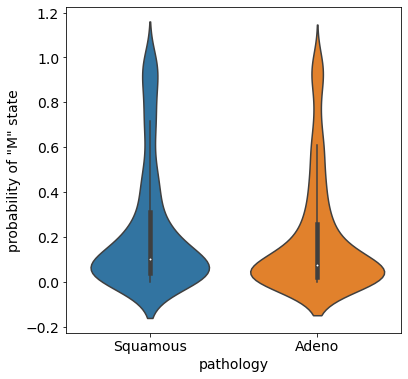

In [13]:
pred_prog2 = pred_prog2[pred_prog2["project_id"] != "TCGA-MESO"]

fig, ax = plt.subplots(figsize=(6, 6))
sns.violinplot(x=pred_prog2['project_id'], y=pred_prog2['prediction'])
#sns.violinplot(x=pred_prog2['project_id'], y=np.log(1+pred_prog2['prediction']))
ax.set_xticklabels(["Squamous", "Adeno"])

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ax.set_xlabel('pathology', size=14)
ax.set_ylabel('probability of "M" state', size=14)

plt.savefig("nn_violin.jpg", format="jpg", bbox_inches="tight")
files.download("nn_violin.jpg")
plt.show()



In [ ]:
pred_prog_part = pred_prog.loc[:,["prediction", "event", "days"]]
cph = CoxPHFitter().fit(pred_prog_part, "days", "event")
cph.print_summary()

/usr/local/lib/python3.6/dist-packages/lifelines/utils/__init__.py:1175: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<lifelines.CoxPHFitter: fitted with 790 total observations, 617 right-censored observations>
             duration col = 'days'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 790
number of events observed = 173
   partial log-likelihood = -1001.61
         time fit was run = 2021-01-12 02:45:59 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
prediction   0.27       1.31       0.20            -0.12             0.67                 0.89                 1.95

              z    p   -log2(p)
covariate                      
prediction 1.35 0.18       2.51
---
Concordance = 0.52
Partial AIC = 2005.21
log-likelihood ratio test = 1.73 on 1 df
-log2(p) of ll-ratio test = 2.40

In [ ]:
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import GridSearchCV

X = data_epi_str_gene_std_1024.T
X = np.array(X.astype("f"))

label = metadata_epi_str["compartment"].values
y = np.where(label=="Epithelial", 0, 1).reshape(-1, 1)

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=0)


In [ ]:
clf = RFC(n_estimators=100, verbose=True, n_jobs=-1, random_state=0)
clf.fit(train_X, train_y)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.2s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=True,
                       warm_start=False)

In [ ]:
clf.score(test_X, test_y)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


0.9996095275283092

In [ ]:
pred_test_y = clf.predict(test_X)
cm3 = confusion_matrix(test_y, pred_test_y)
cm3

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


array([[1878,    0],
       [   1,  682]])

<function matplotlib.pyplot.show>

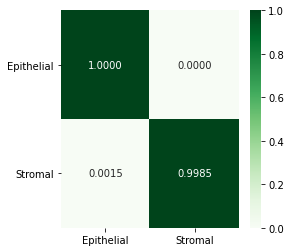

In [ ]:
labels = ["Epithelial", "Stromal"]

cm3 = confusion_matrix(test_y, pred_test_y, normalize="true")
fig, ax = plt.subplots(figsize=(4, 4))

sns.heatmap(cm3, cmap="Greens", xticklabels=labels, yticklabels=labels, annot=True, fmt=".4f", ax=ax)
plt.yticks(rotation=0)
plt.show

In [ ]:
val_X = np.array(tcga_std_gene_1024.T.astype("f"))
pred_val_y =clf.predict(val_X)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


In [ ]:
np.mean(pred_val_y)

0.06563706563706563

In [ ]:
pred_prog = pd.DataFrame(columns=["case_id", "project_id", "age", "gender", "stage", "prediction", "event", "days"])

for i in range(len(tcga_std_gene.columns)):
  id = tcga_std_gene.columns[i]
  prediction = pred_val_y[i]

  with open("/content/drive/My Drive/TCGA/clinical.tsv") as f:
    for s_line in f:
      sample = s_line.split("\t")
      if sample[0] == id:
        project = sample[2]
        age = sample[3]
        gender = sample[11]
        stage = sample[26]
        if sample[15] == "Dead":
          event = 1
        elif sample[15] == "Alive":
          event = 0
        days = sample[47]
        break

  pred_prog.loc[i] = [id, project, age, gender, stage, prediction, event, days]      

pred_prog

,case_id,project_id,age,gender,stage,prediction,event,days
0,9a13a742-ff9a-4432-a7ce-7fcbb753be01,TCGA-LUSC,48,male,Stage IA,1,0,952
1,34f7b63b-7a49-4b29-ab72-d880d87fb7b3,TCGA-LUSC,65,male,Stage IB,0,1,475
2,34040b83-7e8a-4264-a551-b16621843e28,TCGA-LUAD,70,male,Stage IV,0,0,0
3,df7cfd84-a36a-44a0-b39f-a9ea1e0fd500,TCGA-LUSC,63,male,Stage IB,1,0,28
4,9b4eeecb-6aff-435b-a244-ec362af92b7f,TCGA-LUAD,68,male,Stage IIB,0,0,882
...,...,...,...,...,...,...,...,...
1031,ccda26c1-a6d6-4317-8cf8-8a87e15ce12e.2,TCGA-LUAD,63,female,Stage IIB,0,0,944
1032,9b07ef0c-1329-4341-a5a4-42abe7a6737c,TCGA-LUSC,62,male,Stage IB,0,0,3123
1033,abc753f0-5ae2-4bec-96b8-6a05d84bf1c1,TCGA-LUSC,69,female,Stage IIB,0,1,'--
1034,0d3c11b5-856e-4d41-b94a-b2e32f9c5792,TCGA-LUSC,55,male,Stage IA,0,1,'--


/usr/local/lib/python3.6/dist-packages/lifelines/utils/__init__.py:1176: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/usr/local/lib/python3.6/dist-packages/lifelines/utils/__init__.py:1176: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


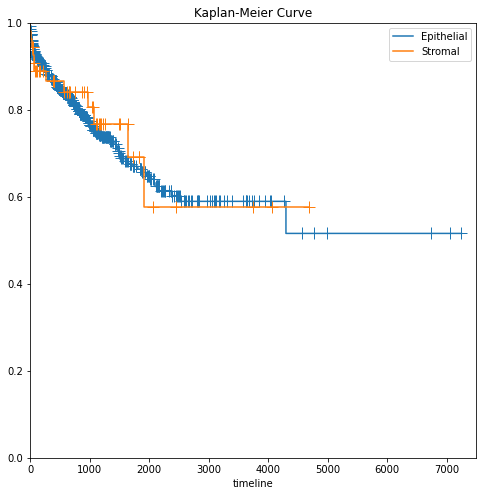

In [ ]:
pred_prog = pred_prog[pred_prog["days"] != "'--"]

kmf = KaplanMeierFitter()

plt.figure(figsize=(8, 8))
ax = None
for name, group in pred_prog.groupby('prediction'):
    kmf.fit(group['days'], event_observed=group['event'],
            label = labels[name])
    # 描画する Axes を指定。None を渡すとエラーになるので場合分け
    if ax is None:
        ax = kmf.plot(show_censors=True, ci_show=False)
    else:
        ax = kmf.plot(ax=ax, show_censors=True, ci_show=False)
plt.title('Kaplan-Meier Curve')
plt.xlim(0, 7500)
plt.ylim(0, 1.0)
plt.show()

In [ ]:
pred_prog = pd.DataFrame(columns=["case_id", "project_id", "age", "gender", "stage", "prediction", "event", "days"])

for i in range(len(tcga_std_gene.columns)):
  id = tcga_std_gene.columns[i]
  prediction = pred_val_y[i][0]

  with open("/content/drive/My Drive/TCGA/clinical.tsv") as f:
    for s_line in f:
      sample = s_line.split("\t")
      if sample[0] == id:
        project = sample[2]
        age = sample[3]
        gender = sample[11]
        stage = sample[26]
        if sample[15] == "Dead":
          event = 1
        elif sample[15] == "Alive":
          event = 0
        days = sample[47]
        break

  pred_prog.loc[i] = [id, project, age, gender, stage, prediction, event, days]      

pred_prog

,case_id,project_id,age,gender,stage,prediction,event,days
0,9a13a742-ff9a-4432-a7ce-7fcbb753be01,TCGA-LUSC,48,male,Stage IA,0.413502,0,952
1,34f7b63b-7a49-4b29-ab72-d880d87fb7b3,TCGA-LUSC,65,male,Stage IB,0.256304,1,475
2,34040b83-7e8a-4264-a551-b16621843e28,TCGA-LUAD,70,male,Stage IV,0.015723,0,0
3,df7cfd84-a36a-44a0-b39f-a9ea1e0fd500,TCGA-LUSC,63,male,Stage IB,0.798071,0,28
4,9b4eeecb-6aff-435b-a244-ec362af92b7f,TCGA-LUAD,68,male,Stage IIB,0.032895,0,882
...,...,...,...,...,...,...,...,...
1031,ccda26c1-a6d6-4317-8cf8-8a87e15ce12e.2,TCGA-LUAD,63,female,Stage IIB,0.192555,0,944
1032,9b07ef0c-1329-4341-a5a4-42abe7a6737c,TCGA-LUSC,62,male,Stage IB,0.112191,0,3123
1033,abc753f0-5ae2-4bec-96b8-6a05d84bf1c1,TCGA-LUSC,69,female,Stage IIB,0.741452,1,'--
1034,0d3c11b5-856e-4d41-b94a-b2e32f9c5792,TCGA-LUSC,55,male,Stage IA,0.095772,1,'--


In [ ]:
pred_prog = pred_prog[pred_prog["project_id"] != "TCGA-MESO"]
sns.violinplot(x=pred_prog['project_id'], y=pred_prog['prediction'])
plt.show()

TypeError: ignored

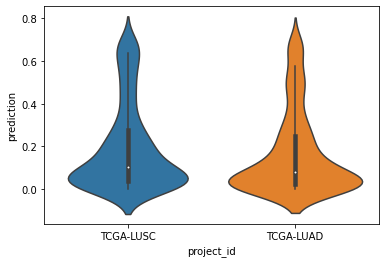

In [ ]:
sns.violinplot(x=pred_prog['project_id'], y=np.log(1+pred_prog['prediction']))
plt.show()